<a href="https://colab.research.google.com/github/Sadia-Khan-Rupa/cancer1/blob/main/Copy_of_Datapreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://github.com/sailalitha96/Lung-Nodule-Detection

In [ ]:
%pip install SimpleITK

     |████████████████████████████████| 47.4MB 65kB/s 


In [ ]:
%pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 102kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
%pip install tensorflow

In [ ]:
%pip install Pillow

In [ ]:
%pip install tflearn

     |████████████████████████████████| 112kB 5.3MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127300 sha256=1f65fc0fa43e26d1b69bd0748aa904529da4a3b07c1728eccb313799308a2c1d
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
%pip install keras

In [ ]:
%pip install utils

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import glob
import SimpleITK as sitk
from PIL import Image
from scipy.misc import imread
from joblib import Parallel, delayed
import tflearn as tf
from tflearn.data_utils import build_hdf5_image_dataset
from scipy.ndimage import rotate, imread
import h5py
%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None


from PIL import Image
from scipy.misc import imread
from joblib import Parallel, delayed
import tflearn as tf
from tflearn.data_utils import build_hdf5_image_dataset
from scipy.ndimage import rotate, imread
import h5py
%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None
import keras
import utils
from keras.layers import Input, merge
from keras.layers import Convolution2D , concatenate ,Conv2D,Dense
from keras.layers import Activation,Dropout, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam ,SGD,RMSprop
#from keras.utils import  to_categorical
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
# print(matplotlib.__file__)
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#### Importing annotations and candidates csv files ####
annotations = pd.read_csv('/content/drive/MyDrive/CSVFILES/annotations.csv')
candidates = pd.read_csv('/content/drive/MyDrive/CSVFILES/candidates.csv')

In [ ]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  551065 non-null  object 
 1   coordX     551065 non-null  float64
 2   coordY     551065 non-null  float64
 3   coordZ     551065 non-null  float64
 4   class      551065 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [ ]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    1186 non-null   object 
 1   coordX       1186 non-null   float64
 2   coordY       1186 non-null   float64
 3   coordZ       1186 non-null   float64
 4   diameter_mm  1186 non-null   float64
dtypes: float64(4), object(1)
memory usage: 46.5+ KB


In [ ]:
# ##################### Samples are heavily imbalanced #####################
print(len(candidates))
print(len(candidates[candidates['class'] == 0]))
print(len(candidates[candidates['class'] == 1]))
print ('percentage of positive cases are ' + str(len(candidates[candidates['class'] == 1])*100.0/len(candidates))+" %")

551065
549714
1351
percentage of positive cases are 0.24516164154863765 %


In [ ]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index
print(positives)
print(negatives)
# ########################## Under sample negative class data ############################

np.random.seed(42)
neg_chosen_index = np.random.choice(negatives, len(positives)*4, replace = False)
#print(neg_chosen_index)

candidates_df = candidates.iloc[list(positives)+list(neg_chosen_index)]
#print(candidates_df)

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)
Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            551055, 551056, 551057, 551058, 551059, 551060, 551061, 551062,
            551063, 551064],
           dtype='int64', length=549714)


In [ ]:
# #################### train_test_split into test and training sets #####################

from sklearn.model_selection import train_test_split
X = candidates_df.iloc[:,:-1]
#print(X)
y = candidates_df.iloc[:,-1]
#print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
#print(y_train)

In [ ]:
# #################################### Splitting training data further for validation set ##################################
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)
#print(y_eval)

In [ ]:
# ############################ Getting the proportions of positive cases in the training data ##############################

# print ('number of positive cases are ' + str(y_train.sum()))
# print ('total set size is ' + str(len(y_train)))
# print ('percentage of positive cases are ' + str(y_train.sum()*100.0/len(y_train))+" %")

In [ ]:
# ############################ Using pickle for data storage ############################
X_train.to_pickle('train_data')
X_test.to_pickle('test_data')
X_eval.to_pickle('eval_data')
y_train.to_pickle('train_labels')
y_test.to_pickle('test_labels')
y_eval.to_pickle('eval_labels')


In [ ]:
class ct_scan_processing(object):
    """
    Class that manipulates and processes over images in the dataset using SimpleITK tools and PIL library.
    Is responsible for:
    1. Read the image from specified filename
    2. Convert the image into it's array representation,
    3. Get coordinates corresponding to origin, voxel,
    4. Reset the coordinates of the original image,
    5. Normalizes the image, 
    6. Writing the modified image back to the file.
    
    """
    def __init__(self, filename = None, coords = None, path = None):
        """
        Constructor to initialize file name, coordinates, image array and PIL image object.
        
        """
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None
        self.file_storage_location = path

    def set_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        file_storage_location = glob.glob('/content/drive/MyDrive/Luna_Dataset/'+self.filename+"*.mhd", recursive =True)
        # Reads the image using SimpleITK
        self.ds = sitk.ReadImage(file_storage_location[0])
         # Convert the image to a  numpy array
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[int(z), int(y-width/2):int(y+width/2), int(x-width/2):int(x+width/2)]
        return subImage   
    
    def normalizePlanes(self, npzarray):
        """
        Normalizing the image using the appropriate maximum and minimum values associated 
        with a CT scan for lung cancer (in terms of Hounsfeld Units)
        
        """
        max_hu = 200.
        min_hu= -1000.
        npzarray = (npzarray - min_hu) / (max_hu - min_hu)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        """
        Converts the normalized cropped image into a grayscale image and store in
        the filename argument specified location.
        
        """
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [ ]:
x=np.asarray(candidates.iloc[negatives[124202]])[0]
print(x)
#x.read_mhd_image()

1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953


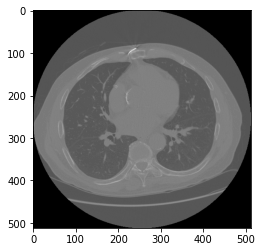

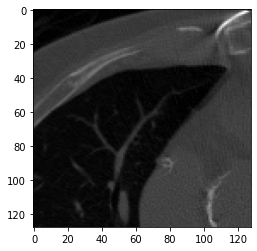

In [ ]:
########################## Testing the ct_scan_processing class for different sub- image sizes #########################

scan = ct_scan_processing(np.asarray(candidates.iloc[negatives[124202]])[0],np.asarray(candidates.iloc[negatives[124202]])[1:-1])
scan.read_mhd_image()
image = scan.get_subimage(2000)
plt.figure()
plt.imshow(image, cmap = 'gray')
image = scan.get_subimage(128)
plt.figure()
plt.imshow(image, cmap = 'gray')

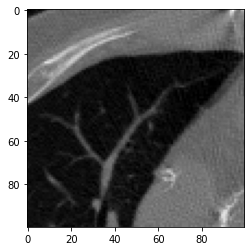

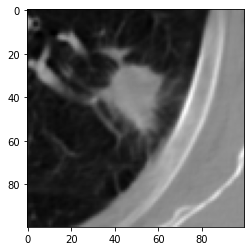

In [ ]:
############################ Testing the ct_scan_processing class on images with and without tumors ############################

scan = ct_scan_processing(np.asarray(candidates.iloc[negatives[124202]])[0],np.asarray(candidates.iloc[negatives[124202]])[1:-1])
scan.read_mhd_image()
image = scan.get_subimage(100)
plt.figure()
plt.imshow(image, cmap = 'gray')

scan = ct_scan_processing(np.asarray(candidates.iloc[positives[1303]])[0],np.asarray(candidates.iloc[positives[1303]])[1:-1])
scan.read_mhd_image()
image = scan.get_subimage(100)
plt.figure()
plt.imshow(image, cmap = 'gray')

In [ ]:
def create_data(idx, outDir, X_data,  width = 50):
    '''
    Aids in creating .jpg variant of original images
    '''
    mhd_image_path = '/content/drive/MyDrive/Luna_Dataset/'
    scan = ct_scan_processing(np.asarray(X_data.loc[idx])[0],np.asarray(X_data.loc[idx])[1:], mhd_image_path)
    outfile = outDir  +  str(idx)+ '.jpg'
    scan.save_image(outfile, width)

############################### Converting .mhd files to .jpg (cropped to recognize the nodules) ##############################

#X_test_data = pd.read_pickle('test_data')
#test_dir = '/content/drive/MyDrive/test/image_'
#Parallel(n_jobs = 12)(delayed(create_data)(i, test_dir, X_test_data) for i in X_test_data.index)


#X_train_data = pd.read_pickle('train_data')
#train_dir = '/content/drive/MyDrive/train_again/image_'
#Parallel(n_jobs = 12)(delayed(create_data)(i, train_dir, X_train_data) for i in X_train_data.index)

#X_val_data = pd.read_pickle('eval_data')
#validation_dir = '/content/drive/MyDrive/val_again/image_'
#Parallel(n_jobs = 8)(delayed(create_data)(i, validation_dir, X_val_data) for i in X_val_data.index)

In [ ]:
#os.chdir('/content/drive/MyDrive/val_again/')
#!ls

In [ ]:
#os.chdir('/content/drive/MyDrive/train_again/')
#!ls

In [ ]:
'''
mode = 'val_again'
input_image = imread('/content/drive/MyDrive/'+ mode +'/image_' + str(267648)+ '.jpg')
plt.figure()
plt.imshow(input_image, cmap = 'gray')

input_to_90 = rotate(input_image, 90, reshape = False)
plt.figure()
plt.imshow(input_to_90, cmap = 'gray')

Image.fromarray(input_to_90).convert('L').save('/content/drive/MyDrive/val_again/' +'image_' + str(267648+1000000) + '.jpg')
a=imread('/content/drive/MyDrive/'+ mode +'/image_' + str(267648+1000000)+ '.jpg')
plt.figure()
plt.imshow(a, cmap = 'gray')

input_to_180 = rotate(input_image, 180, reshape = False)
plt.figure()
plt.imshow(input_to_180, cmap = 'gray')

Image.fromarray(input_to_180).convert('L').save('/content/drive/MyDrive/val_again/' + 'image_' + str(267648+2000000) + '.jpg')
b=imread('/content/drive/MyDrive/'+ mode +'/image_' + str(267648+2000000)+ '.jpg')
plt.figure()
plt.imshow(b, cmap = 'gray')
'''


"\nmode = 'val_again'\ninput_image = imread('/content/drive/MyDrive/'+ mode +'/image_' + str(267648)+ '.jpg')\nplt.figure()\nplt.imshow(input_image, cmap = 'gray')\n\ninput_to_90 = rotate(input_image, 90, reshape = False)\nplt.figure()\nplt.imshow(input_to_90, cmap = 'gray')\n\nImage.fromarray(input_to_90).convert('L').save('/content/drive/MyDrive/val_again/' +'image_' + str(267648+1000000) + '.jpg')\na=imread('/content/drive/MyDrive/'+ mode +'/image_' + str(267648+1000000)+ '.jpg')\nplt.figure()\nplt.imshow(a, cmap = 'gray')\n\ninput_to_180 = rotate(input_image, 180, reshape = False)\nplt.figure()\nplt.imshow(input_to_180, cmap = 'gray')\n\nImage.fromarray(input_to_180).convert('L').save('/content/drive/MyDrive/val_again/' + 'image_' + str(267648+2000000) + '.jpg')\nb=imread('/content/drive/MyDrive/'+ mode +'/image_' + str(267648+2000000)+ '.jpg')\nplt.figure()\nplt.imshow(b, cmap = 'gray')\n"

In [ ]:
################################################ Data Augmentation using scipy ###############################################
def data_augmentation_module(idx, mode):
    '''
    Performs an angular transfirmation of images to yield data for augmentation. This helps us compensates for lack of
    sufficient positive cases in the data.
    '''
    #input_image = imread('/content/drive/MyDrive/'+ mode +'/image_' + str(idx)+ '.jpg')
#     plt.figure()
#     plt.imshow(input_image, cmap = 'gray')
    # Rotate by 90 and saving it in the train folder with new index
    #input_to_90 = rotate(input_image, 90, reshape = False)
    #Image.fromarray(input_to_90).convert('L').save('/content/drive/MyDrive/train_again/' +'image_' + str(idx+1000000) + '.jpg')
    # Rotate by 180 and saving it in the train folder with new index
    #input_to_180 = rotate(input_image, 180, reshape = False)
    #Image.fromarray(input_to_180).convert('L').save('/content/drive/MyDrive/train_again/' + 'image_' + str(idx+2000000) + '.jpg')

#X_train = pd.read_pickle('train_data')
#mode = 'train_again'
#y_train = pd.read_pickle('train_labels')
#indices = X_train[y_train == 1].index

#Parallel(n_jobs = 8)(delayed(data_augmentation_module)(i,mode) for i in indices)


In [ ]:
os.chdir('/content/drive/MyDrive/train_again/')
!ls

eval_data	   image_2138965.jpg  image_362506.jpg
eval_labels	   image_2139049.jpg  image_362552.jpg
image_1000013.jpg  image_2139078.jpg  image_362920.jpg
image_1000078.jpg  image_2139171.jpg  image_362938.jpg
image_100035.jpg   image_2139444.jpg  image_362974.jpg
image_10004.jpg    image_2139484.jpg  image_363001.jpg
image_100176.jpg   image_2139508.jpg  image_363235.jpg
image_100231.jpg   image_214137.jpg   image_363388.jpg
image_100235.jpg   image_214142.jpg   image_36356.jpg
image_1003080.jpg  image_2141871.jpg  image_363623.jpg
image_1003223.jpg  image_2142156.jpg  image_364178.jpg
image_1003285.jpg  image_2142381.jpg  image_364207.jpg
image_1003289.jpg  image_2142730.jpg  image_364403.jpg
image_1003303.jpg  image_2144274.jpg  image_364540.jpg
image_1003401.jpg  image_214556.jpg   image_364603.jpg
image_1003406.jpg  image_214603.jpg   image_364773.jpg
image_1003461.jpg  image_2146708.jpg  image_364793.jpg
image_100365.jpg   image_2146807.jpg  image_364832.jpg
image_100406.jpg   im

In [ ]:
'''
mode='val_again'
b=plt.imread('/content/drive/MyDrive/'+ mode +'/image_' + str(81709)+ '.jpg')
plt.figure()
plt.imshow(b, cmap = 'gray')
c=plt.imread('/content/drive/MyDrive/'+ mode +'/image_' + str(1081709)+ '.jpg')
plt.figure()
plt.imshow(c, cmap = 'gray')
d=plt.imread('/content/drive/MyDrive/'+ mode +'/image_' + str(2081709)+ '.jpg')
plt.figure()
plt.imshow(d, cmap = 'gray')
'''

"\nmode='val_again'\nb=plt.imread('/content/drive/MyDrive/'+ mode +'/image_' + str(81709)+ '.jpg')\nplt.figure()\nplt.imshow(b, cmap = 'gray')\nc=plt.imread('/content/drive/MyDrive/'+ mode +'/image_' + str(1081709)+ '.jpg')\nplt.figure()\nplt.imshow(c, cmap = 'gray')\nd=plt.imread('/content/drive/MyDrive/'+ mode +'/image_' + str(2081709)+ '.jpg')\nplt.figure()\nplt.imshow(d, cmap = 'gray')\n"

In [ ]:
#a = X_train[y_train == 1].index
#print(a)

In [ ]:
#os.chdir('/content/drive/MyDrive/train_again/')
#!ls

In [ ]:
'''
mode='train'
X = pd.read_pickle('train' + '_data')
y = pd.read_pickle('train' + '_labels')  
index_list = X.index.to_series()
files = index_list.apply(lambda x:'/content/drive/MyDrive/'+ mode+ '/image_'+str(x)+'.jpg')
pos_indices = []
for i in y[y==1].index:
      pos_indices.append([i+1000000])
index = [i+1000000 for i in y[y==1].index]
pos_indices = pd.Series( (v[0] for v in pos_indices), index = index)
files_aug_1 = pos_indices.apply(lambda x:'/content/drive/MyDrive/'+ mode+ '/image_'+str(x)+'.jpg')
files = files.append(files_aug_1)

pos_indices = []
for i in y[y==1].index:
    pos_indices.append([i+2000000])
index = [i+2000000 for i in y[y==1].index]
pos_indices = pd.Series( (v[0] for v in pos_indices), index = index)
files_aug_2 = pos_indices.apply(lambda x:'/content/drive/MyDrive/'+ mode+ '/image_'+str(x)+'.jpg')
files = files.append(files_aug_2)
# Adding labels for augmented images to y
pos_idx = [i+1000000 for i in y[y==1].index]
labels_aug_1 = [[1] for i in range(len(y[y==1].index))]
y_1 = pd.Series( (v[0] for v in labels_aug_1), index = pos_idx)
pos_idx = [i+2000000 for i in y[y==1].index]
labels_aug_2 = [[1] for i in range(len(y[y==1].index))]
y_2 = pd.Series( (v[0] for v in labels_aug_1), index = pos_idx)
y = y.append(y_1)
y = y.append(y_2)
# Convert files and labels to arrays
files = files.values.astype(str)
labels = y.values.astype(int)
dataset = pd.DataFrame({'files':files,'labels':labels})
dataset_file = mode + '_data_labels.txt'
np.savetxt(dataset_file, dataset, fmt="%10s %d")
hdf5_file_name = mode + 'dataset.h5'
build_hdf5_image_dataset(dataset_file, image_shape = (50, 50, 1),mode ='file', output_path = hdf5_file_name, 
    categorical_labels = True, normalize = True, grayscale = True)

'''

'\nmode=\'train\'\nX = pd.read_pickle(\'train\' + \'_data\')\ny = pd.read_pickle(\'train\' + \'_labels\')  \nindex_list = X.index.to_series()\nfiles = index_list.apply(lambda x:\'/content/drive/MyDrive/\'+ mode+ \'/image_\'+str(x)+\'.jpg\')\npos_indices = []\nfor i in y[y==1].index:\n      pos_indices.append([i+1000000])\nindex = [i+1000000 for i in y[y==1].index]\npos_indices = pd.Series( (v[0] for v in pos_indices), index = index)\nfiles_aug_1 = pos_indices.apply(lambda x:\'/content/drive/MyDrive/\'+ mode+ \'/image_\'+str(x)+\'.jpg\')\nfiles = files.append(files_aug_1)\n\npos_indices = []\nfor i in y[y==1].index:\n    pos_indices.append([i+2000000])\nindex = [i+2000000 for i in y[y==1].index]\npos_indices = pd.Series( (v[0] for v in pos_indices), index = index)\nfiles_aug_2 = pos_indices.apply(lambda x:\'/content/drive/MyDrive/\'+ mode+ \'/image_\'+str(x)+\'.jpg\')\nfiles = files.append(files_aug_2)\n# Adding labels for augmented images to y\npos_idx = [i+1000000 for i in y[y==1].ind

In [ ]:
#os.chdir('/content/drive/MyDrive/train_again/')
#!ls

In [ ]:
###################################### Building HD5 dataset with tensorflow ######################################

def pickle_to_hdf5_file(mode):
     
    X = pd.read_pickle('train' + '_data')
    y = pd.read_pickle('train' + '_labels')  
    index_list = X.index.to_series()    
    files = index_list.apply(lambda x:'/content/drive/MyDrive/'+ mode+ '/image_'+str(x)+'.jpg')
    # Add augmented images to files
    pos_indices = []
    for i in y[y==1].index:
        pos_indices.append([i+1000000])
    index = [i+1000000 for i in y[y==1].index]
    pos_indices = pd.Series( (v[0] for v in pos_indices), index = index)
    files_aug_1 = pos_indices.apply(lambda x:'/content/drive/MyDrive/'+ mode+ '/image_'+str(x)+'.jpg')
    
    pos_indices = []
    for i in y[y==1].index:
        pos_indices.append([i+2000000])
    index = [i+2000000 for i in y[y==1].index]
    pos_indices = pd.Series( (v[0] for v in pos_indices), index = index)
    files_aug_2 = pos_indices.apply(lambda x:'/content/drive/MyDrive/'+ mode+ '/image_'+str(x)+'.jpg')
    files = files.append(files_aug_1)
    files = files.append(files_aug_2)
    # Adding labels for augmented images to y
    pos_idx = [i+1000000 for i in y[y==1].index]
    labels_aug_1 = [[1] for i in range(len(y[y==1].index))]
    y_1 = pd.Series( (v[0] for v in labels_aug_1), index = pos_idx)
    pos_idx = [i+2000000 for i in y[y==1].index]
    labels_aug_2 = [[1] for i in range(len(y[y==1].index))]
    y_2 = pd.Series( (v[0] for v in labels_aug_1), index = pos_idx)
    y = y.append(y_1)
    y = y.append(y_2)
    # Convert files and labels to arrays
    files = files.values.astype(str)
    labels = y.values.astype(int)
    # Arrays -> Dataset
    dataset = pd.DataFrame({'files':files,'labels':labels})
    # Dataset -> Interim Storage in a text file
    dataset_file = mode + '_data_labels.txt'
    np.savetxt(dataset_file, dataset, fmt="%10s %d")
    # Text File -> HDF5 images dataset
    hdf5_file_name = mode + 'dataset.h5'
    build_hdf5_image_dataset(dataset_file, image_shape = (50, 50, 1),mode ='file', output_path = hdf5_file_name, 
    categorical_labels = True, normalize = True, grayscale = True)


In [ ]:
#os.chdir('/content/drive/MyDrive/train_again/')
#!ls

In [ ]:
 modes = ['train_again', 'val_again', 'test']

# # Validation HDF5
#pickle_to_hdf5_file(modes[1])
# # Train HDF5
#pickle_to_hdf5_file(modes[0])
# # # Test HDF5
#pickle_to_hdf5_file(modes[2])

In [ ]:
'''
mode='val_again'
h5_file = h5py.File(mode+ 'dataset.h5', 'r')
images = h5_file ['X']
labels = h5_file ['Y'][:]
images = images[:,:,:].reshape([-1,50,50,1])
print(images)
'''

"\nmode='val_again'\nh5_file = h5py.File(mode+ 'dataset.h5', 'r')\nimages = h5_file ['X']\nlabels = h5_file ['Y'][:]\nimages = images[:,:,:].reshape([-1,50,50,1])\nprint(images)\n"

In [ ]:
################################################## Loading HDF5 dataset ######################################################

# Load HDF5 dataset
def load_hdf_dataset(mode):
    h5_file = h5py.File(mode+ 'dataset.h5', 'r')
    images = h5_file ['X']
    labels = h5_file ['Y'][:]
    
    images = images[:,:,:].reshape([-1,50,50,1])
    h5_file.close()
    return images, labels 




train_images , labels = load_hdf_dataset('train_again')

print(labels[0])

val_images , val_labels = load_hdf_dataset('val_again')

print(train_images.shape)



[1. 0.]
(6055, 50, 50, 1)


https://note.nkmk.me/en/python-numpy-reshape-usage/

In [ ]:
def build_squeezenet(input_shape):
    
    input_layer = Input(shape = input_shape)
    
    out = Conv2D(96, kernel_size =(3, 3), activation='relu')(input_layer)
    out = MaxPooling2D(pool_size=2, strides=None, padding='valid')(out)
    # no mxpooling done since small images 
    out = fire_module(out,squeeze =16 , expansion =64)
    out = fire_module(out,squeeze = 16 , expansion=64)
    
    out = fire_module(out,squeeze= 32,expansion = 128)
    out = fire_module(out,squeeze= 32,expansion = 128)
    
    out = fire_module(out , squeeze = 48 ,expansion=192)
    out = fire_module(out,squeeze = 48 , expansion = 192)
    
    out = fire_module(out,squeeze = 64 , expansion = 256)
    out = fire_module(out,squeeze = 64 , expansion = 256)
    
    out = Dropout(0.5)(out)
    
    out = Conv2D(2,kernel_size=(1,1),padding='valid',activation='tanh')(out)
    
    out = GlobalAveragePooling2D()(out)
    out = Dense(2, activation="sigmoid")(out)
       
    model = Model(input_layer, out, name='squeezenet')
    return model  

def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

In [ ]:
def fire_module(input_layer, squeeze =16 , expansion =32):

# a definition for fire module et.al https://github.com/rcmalli/keras-squeezenet/
# inspiration out = tf.map_fn(lambda x: threshold_binarize(x, threshold=0.5) , out, dtype=tf.int64)
# squeezing using 1x1 kernel and expansion with 1x1 and 3x3. Concatenate the output to get best result.

    fire_sq = Conv2D(squeeze,1,1,activation='relu')(input_layer)
    fire_exp1 = Conv2D(expansion ,kernel_size=(1,1),activation='tanh',padding='valid')(fire_sq)
    fire_exp2 = Conv2D(expansion ,kernel_size=(3,3),activation='tanh',padding='same')(fire_sq)
    out = concatenate([fire_exp1,fire_exp2], axis=3)

    return out

https://github.com/keras-team/keras/issues/5427


In [ ]:
model_dw = build_squeezenet(input_shape= (50,50,1))

sgd = keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_dw.compile(optimizer=sgd, loss='binary_crossentropy',metrics=['accuracy'])
#model_dw.summary()
model_dw.fit(x=train_images, 
             y=labels, 
             batch_size=64,
             epochs=10, 
             verbose=1,  
             validation_split=0.2,
             validation_data=(val_images,val_labels), 
             shuffle=True)

pred = model_dw.predict(val_images)

Train on 6055 samples, validate on 1501 samples
Epoch 1/10


FailedPreconditionError: ignored

In [ ]:
pred[pred<=0.5]

In [ ]:
model_dw.summary()